# Best Scoring 0.06037
# Best place 3584/4082 (Top 87%)
https://www.kaggle.com/competitions/playground-series-s5e10/leaderboard?tab=public

# TODO: 1. Use move average model like RandomForest, GradientBoosting and VotingRegressor
# TODO: 2. Use more powerful model like XGBoost, LightGBM or CatBoost with hyperparameter tuning
# TODO: 3. Try use DNN model with PyTorch or TensorFlow/Keras

In [28]:
import numpy as np
import optuna
import pandas as pd
from optuna.samplers import TPESampler
from optuna.visualization import plot_parallel_coordinate
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from utils import EarlyStoppingCallback


In [30]:
test = pd.read_csv('./data/road_accident/test.csv', index_col='id')
train = pd.read_csv('./data/road_accident/train.csv', index_col='id')
submission_example = pd.read_csv('./data/road_accident/sample_submission.csv')

In [31]:
one_hot_columns = ['weather', 'lighting', 'road_type']
label_columns = ['time_of_day']
numeric_columns = ['num_lanes', 'speed_limit', 'num_reported_accidents']

In [32]:
# --- fit on train ---
scaler = StandardScaler()
train[numeric_columns] = scaler.fit_transform(train[numeric_columns])

ordinal_encoder = OrdinalEncoder()
train[label_columns] = ordinal_encoder.fit_transform(train[label_columns])

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_encoded = one_hot_encoder.fit_transform(train[one_hot_columns])
train_encoded_df = pd.DataFrame(
    train_encoded,
    columns=one_hot_encoder.get_feature_names_out(one_hot_columns),
    index=train.index,  # keep index
)
train = pd.concat([train.drop(columns=one_hot_columns), train_encoded_df], axis=1)

# --- transform test with the SAME fitted objects ---
test[numeric_columns] = scaler.transform(test[numeric_columns])
test[label_columns] = ordinal_encoder.transform(test[label_columns])

test_encoded = one_hot_encoder.transform(test[one_hot_columns])
test_encoded_df = pd.DataFrame(
    test_encoded,
    columns=one_hot_encoder.get_feature_names_out(one_hot_columns),
    index=test.index,  # keep index
)
test = pd.concat([test.drop(columns=one_hot_columns), test_encoded_df], axis=1)

0


In [33]:
# let's add column for stratification named 'stratify_col' based on 'accident_risk' column
train['stratify_col'] = pd.qcut(train['accident_risk'], q=5, labels=False)

In [34]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop(columns=['accident_risk']),
    train['accident_risk'],
    test_size=0.2,
    random_state=42,
    stratify=train['stratify_col']
)

In [23]:
# lets check data distribution in stratify_col
print("Train stratify_col distribution:")
print(X_train['stratify_col'].value_counts(normalize=True))
print("\nValidation stratify_col distribution:")
print(X_valid['stratify_col'].value_counts(normalize=True))

Train stratify_col distribution:
stratify_col
0    0.216807
3    0.209598
2    0.195754
1    0.190411
4    0.187430
Name: proportion, dtype: float64

Validation stratify_col distribution:
stratify_col
0    0.216801
3    0.209597
2    0.195759
1    0.190409
4    0.187434
Name: proportion, dtype: float64


In [36]:
# we can drop 'stratify_col' now
X_train = X_train.drop(columns=['stratify_col'])
X_valid = X_valid.drop(columns=['stratify_col'])

In [37]:
# Let's use a more complex model ( Random Forest Regressor )
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# check validation RMSE
y_pred_rf = rf_model.predict(X_valid)
mse_rf = mean_squared_error(y_valid, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f"Validation RMSE (Random Forest): {rmse_rf}") # 0.05967272261131153

# check train RMSE
y_train_pred_rf = rf_model.predict(X_train)
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(train_mse_rf)
print(f"Train RMSE (Random Forest): {train_rmse_rf}") # 0.022946553865230764

# Model is too Heavy 1m3s for training on 80% of data
# Model is Overfitted ( need regularization or hyperparameter tuning )

Validation RMSE (Random Forest): 0.05967272261131153
Train RMSE (Random Forest): 0.022946553865230764


In [38]:
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr_model.fit(X_train, y_train)

# check validation RMSE
y_pred_gbr = gbr_model.predict(X_valid)
mse_gbr = mean_squared_error(y_valid, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
print(f"Validation RMSE (Gradient Boosting): {rmse_gbr}") # 0.05735951926241409

# check train RMSE
y_train_pred_gbr = gbr_model.predict(X_train)
train_mse_gbr = mean_squared_error(y_train, y_train_pred_gbr)
train_rmse_gbr = np.sqrt(train_mse_gbr)
print(f"Train RMSE (Gradient Boosting): {train_rmse_gbr}") # 0.05673532027193688

# Model is well-balanced and accurate enough
# Time training 1m27s

Validation RMSE (Gradient Boosting): 0.05735951926241409
Train RMSE (Gradient Boosting): 0.05673532027193688


In [39]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# check validation RMSE
y_pred_dt = dt_model.predict(X_valid)
mse_dt = mean_squared_error(y_valid, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print(f"Validation RMSE (Decision Tree): {rmse_dt}") # 0.08283735076947037

# check train RMSE
y_train_pred_dt = dt_model.predict(X_train)
train_mse_dt = mean_squared_error(y_train, y_train_pred_dt)
train_rmse_dt = np.sqrt(train_mse_dt)
print(f"Train RMSE (Decision Tree): {train_rmse_dt}") # 0.00743117343653974

# Model is Overfitted ( need regularization or hyperparameter tuning )
# But his model provide most accurate results

Validation RMSE (Decision Tree): 0.08283735076947037
Train RMSE (Decision Tree): 0.00743117343653974


In [40]:
def objective(trial):

    model = LinearSVR(
        C=trial.suggest_float('C', 1e-5, 100.0, log=True),
        epsilon=trial.suggest_float('epsilon', 1e-5, 1.0, log=True),
        max_iter=trial.suggest_int('max_iter', 10, 100),
        tol=trial.suggest_float('tol', 1e-5, 1e-1, log=True),
        random_state=42
    )

    score = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )

    rmse = np.sqrt(-score.mean())

    return rmse

In [41]:
study = optuna.create_study(direction='minimize', sampler=TPESampler())

study.optimize(objective,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,
               callbacks=[EarlyStoppingCallback(patience=10, min_delta=0.0001)])

[I 2025-12-29 21:53:52,857] A new study created in memory with name: no-name-4de234f3-bf94-41de-a647-812001922b92


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-29 21:54:15,413] Trial 4 finished with value: 0.07341776033408859 and parameters: {'C': 0.0004203362733436017, 'epsilon': 0.0011863322632095772, 'max_iter': 25, 'tol': 0.0014892352238236985}. Best is trial 4 with value: 0.07341776033408859.
[I 2025-12-29 21:54:16,695] Trial 7 finished with value: 0.07417905227940962 and parameters: {'C': 3.253139557386434e-05, 'epsilon': 0.0024102088001085433, 'max_iter': 25, 'tol': 0.09865922315966824}. Best is trial 4 with value: 0.07341776033408859.
[I 2025-12-29 21:54:17,607] Trial 3 finished with value: 0.07350816927506056 and parameters: {'C': 0.0002476850951398846, 'epsilon': 0.00025997839201270323, 'max_iter': 43, 'tol': 0.03212956412036594}. Best is trial 4 with value: 0.07341776033408859.
[I 2025-12-29 21:54:19,158] Trial 5 finished with value: 0.07343307894651781 and parameters: {'C': 0.002858643135895512, 'epsilon': 0.0001580205321534327, 'max_iter': 22, 'tol': 0.0037458447420939873}. Best is trial 4 with value: 0.073417760334088

In [42]:
study.best_value

0.07340752307953825

In [43]:
study.best_params

{'C': 0.008781524984327764,
 'epsilon': 0.004022326966449261,
 'max_iter': 53,
 'tol': 1.5049965686235807e-05}

In [44]:
plot_parallel_coordinate(study)

In [45]:
dtree = DecisionTreeRegressor(
    **{'max_depth': 19,
       'min_samples_split': 6,
       'min_samples_leaf': 7,
       'max_leaf_nodes': 561},
    criterion='friedman_mse',
    splitter='best',
    random_state=42,
)

lasso = Lasso(
    **{'alpha': 1.5057733160712574e-05,
       'copy_X': False,
       'max_iter': 998527,
       'precompute': False},
    warm_start=True,
    fit_intercept=True,
    random_state=42
)
linear_svr = LinearSVR(
    **{'C': 0.00019537116696778474,
       'epsilon': 0.05540793674577588,
       'max_iter': 42,
       'tol': 2.1541452249659088e-05},
    random_state=42
)

In [46]:
estimators=[('dtree', dtree), ('lasso', lasso), ('linear_svr', linear_svr)]
voting_reg = VotingRegressor(estimators=estimators, n_jobs=-1, verbose=1, weights=[1,1,1])

In [48]:
# let's use GridSearchCV to find best hyperparameters for Voting Regressor

param_grid = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]],
}

grid_search = GridSearchCV(estimator=voting_reg,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=cv,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

print(f'Best parameters for Voting Regressor: {grid_search.best_params_}')
print(f'Best cross-validation score: {np.sqrt(-grid_search.best_score_)}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Voting Regressor: {'weights': [2, 1, 1]}
Best cross-validation score: 0.06083112848179008


In [51]:
best_model = VotingRegressor(estimators=estimators, n_jobs=-1, verbose=1, weights=[2, 1, 1])

In [52]:
# let's fit model on whole training data (X_train and X_valid)
X_full_train = np.vstack((X_train, X_valid))
y_full_train = np.hstack((y_train, y_valid))

best_model.fit(X_full_train, y_full_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingRegressor`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('dtree', ...), ('lasso', ...), ...]"
,"weights weights: array-like of shape (n_regressors,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted values before averaging. Uses uniform weights if `None`.","[2, 1, ...]"
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",-1
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",1
,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'friedman_mse'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",19
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",6
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",7
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_fea

In [56]:
y_pred_train = best_model.predict(X_full_train)

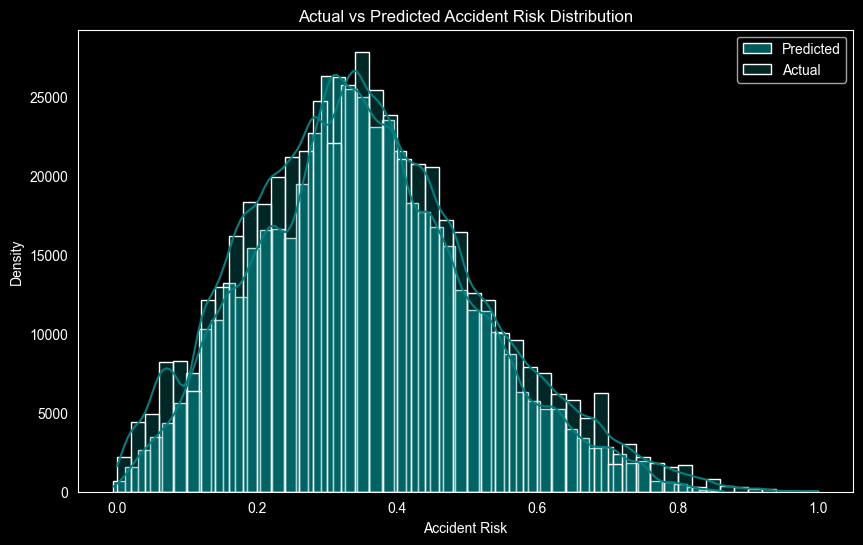

In [64]:
# let's compare histograms of actual and predicted accident_risk on full training data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_pred_train, kde=True, bins=50, color='teal', label='Predicted', alpha=0.7)
sns.histplot(y_full_train, kde=True, bins=50, color='teal', label='Actual', alpha=0.3)

# plt.hist(y_pred_train, bins=50, alpha=0.7, label='Predicted', color='orange', density=True)
# plt.hist(y_full_train, bins=50, alpha=0.7, label='Actual', color='orange', density=True)

plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('Actual vs Predicted Accident Risk Distribution')
plt.legend()
plt.grid()
plt.show()

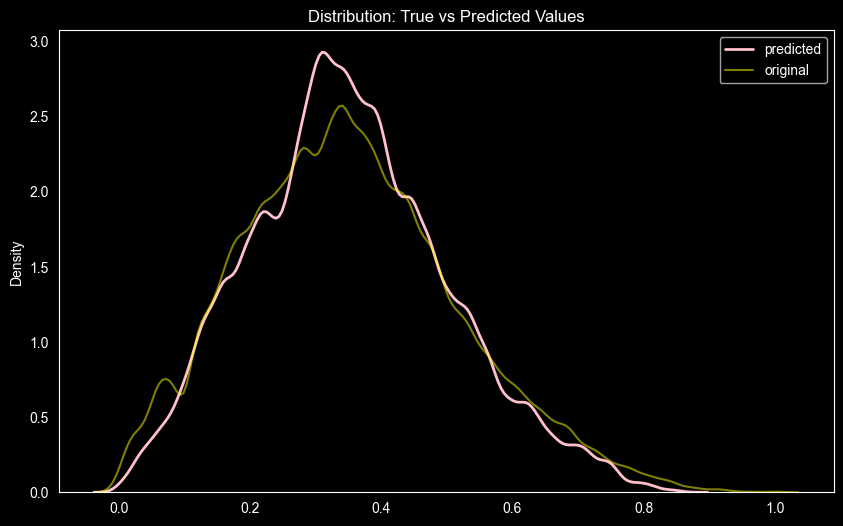

In [68]:
# 1. True values vs.   Model OOF Comparison of the distribution of predicted values
# plt.subplot(1, 2, 1)
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred_train, label='predicted', color='pink', linewidth=2)
sns.kdeplot(y_full_train, label='original', color='yellow', alpha=0.5)
plt.title('Distribution: True vs Predicted Values')
plt.grid()
plt.legend()

In [53]:
y_pred = best_model.predict(test)

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning:

X has feature names, but Lasso was fitted without feature names

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning:

X has feature names, but LinearSVR was fitted without feature names



In [ ]:
# TODO: check score on training and validation set ( Overfitting / Underfitting )

In [54]:
# let's contact test id with predicted accident_risk
submission = pd.DataFrame({
    'id': test.index,
    'accident_risk': y_pred
})

In [ ]:
submission.to_csv('./data/road_accident/submission.csv', index=False)

# Resume: current score dosn't good for best solutions on leaderboard (0.06037 vs 0.05000), we need to improve model to get score about 0.05+ RMSE.